In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_fDE import Class
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.optimize import minimize, brentq, curve_fit
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, LogLocator, NullFormatter
from matplotlib.patches import Patch
import scienceplots
import seaborn as sns
import matplotlib as mpl
from scipy.optimize import curve_fit
from matplotlib import cm
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.colors as mcolors
plt.style.use('mine.mplstyle')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amssymb}"
})

In [2]:
_c_in_km_s= 299792.458

def get_bg_evolution(cosmo,global_settings,cosmo_settings, zmax=4):
    cosmo.set(global_settings)
    cosmo.set(cosmo_settings)
    cosmo.compute()
    bg= cosmo.get_background()
    z=bg['z']
    Hz= np.vectorize(cosmo.Hubble)(z)*_c_in_km_s 
    rho_crit = bg["(.)rho_crit"]
    rho_b = bg["(.)rho_b"]
    rho_cdm= bg["(.)rho_cdm"]
    rho_m=rho_b+rho_cdm
    Omega_m=rho_m/rho_crit
    H0=cosmo.h()*100
    rho_DE = bg["(.)rho_scf"]
    p_DE = bg["(.)p_scf"]
    w_DE = p_DE/rho_DE
    return {'H': Hz[z<=zmax], 'z': z[z<=zmax], 'rhoDE': rho_DE[z<=zmax], 'wDE':w_DE[z<=zmax], 'H0':H0, 'OmegaM':Omega_m[z<=zmax]}

In [3]:
#reduced Plank mass
Mpl = 2.235e27

common_params = {
    'output': '',
    # Cosmological parameters
    'h': 0.6821,
    'A_s': 2.216e-9,
    'n_s': 0.9686,
    'omega_b': 0.02253,
    'omega_cdm': 0.1177,
    'tau_reio': 0.085,

    # Neutrinos and relativistic species
    #'N_ncdm': 1,
    'N_ur': 3.044,
    #'m_ncdm': 0.06,

    # Verbosity
    #'input_verbose': 10,
    #'background_verbose': 10,
    #'perturbations_verbose': 1,

    # Dark energy and curvature
    'Omega_Lambda': 0.0,
    'Omega_fld': 0.0,
    'Omega_scf': -1, ## setting -1 tells class to set Omega0_scf = 1 - Sum_i Omega0_i
    # Scalar field (SCF) parameters
    'scf_parameters': '0.0,0.0,0.0,0.0,0.0,0.0', # just a dummy place holder for, filled w/ scf below by class
    'scf_tuning_index': 1, ## this tunes V_0 in the potential to fulfill the bidget equation: V(chi) ~ V_0 (1 - 0.5 K^2 phi^2)
    'attractor_ic_scf': 'no',
     'Lambda0_scf':1., 
}
lambda_scf =0.6
phi_i_scf =0

expDE_pars = {
    'scf_potential': 'exponential',
    'lambda_scf': lambda_scf, # units of M_pl ^-1
    'phi_i_scf': phi_i_scf, # units of M_pl
}

expDE = Class()
DictExpDE=get_bg_evolution(expDE, common_params, expDE_pars)
del expDE

K_scf = 3
phi_i_scf = 1e-2
htDE_pars = {
    'K_scf':K_scf, # units of M_pl ^-1
    'phi_i_scf':phi_i_scf, # units of M_pl
    'scf_potential': 'hilltop',
}
htDE = Class()
DictHtDE=get_bg_evolution(htDE, common_params, htDE_pars)
del htDE

In [15]:
def Hz_faDE(z, fa,Omega_m,H0):
    zp1 = 1.0 + z
    fDE=1+fa*z/zp1
    E2 = (Omega_m * zp1**3 +
          (1 - Omega_m) * fDE)
    return H0 * np.sqrt(E2)

def Hz_w0wa(z, w0,wa,Omega_m,H0):
    zp1 = 1.0 + z
    E2 = (Omega_m * zp1**3 +
          (1 - Omega_m) *zp1**(3 * (1 + w0 + wa)) *
              np.exp(-3 * wa* z / zp1))
    return H0 * np.sqrt(E2)
    
def Hz_faDE2(z, fa,fb,Omega_m,H0):
    zp1 = 1.0 + z
    fDE=1+fa*z/zp1+fb*(z/zp1)**2
    E2 = (Omega_m * zp1**3 +
          (1 - Omega_m) * fDE)
    return H0 * np.sqrt(E2)

def w_faDE(z, fa):
    a=1./(1.+z)
    return -1+ fa*a/(3*(1+(1-a)*fa))

def w_w0wa(z, w0,wa):
    zp1 = 1.0 + z
    return  ( w0 + wa*z/zp1)
    
def w_faDE2(z, fa,fb):
    a=1./(1.+z)
    zp1 = 1.0 + z
    fDE=1+fa*z/zp1+fb*(z/zp1)**2
    dfDEda=-(fa+2*fb*z/zp1)
    return -1 -a/(3*fDE)*dfDEda
    
def get_fits(DictDE):
    Hz_faDE_fit = lambda z, fa: Hz_faDE(z, fa, DictDE['OmegaM'][-1], DictDE['H0'])
    Hz_faDE2_fit = lambda z, fa, fb: Hz_faDE2(z, fa, fb, DictDE['OmegaM'][-1], DictDE['H0'])
    Hz_w0wa_fit = lambda z, w0, wa: Hz_w0wa(z, w0,wa, DictDE['OmegaM'][-1], DictDE['H0'])
    popt, pcov = curve_fit(
    Hz_faDE_fit,
    DictDE['z'],
    DictDE['H'],
    p0=[0.0]
    )
    popt2, pcov2 = curve_fit(
    Hz_faDE2_fit,
    DictDE['z'],
    DictDE['H'],
    p0=[0.0, 0.0]
    )
    popt3, pcov3 = curve_fit(
    Hz_w0wa_fit,
    DictDE['z'],
    DictDE['H'],
    p0=[-1.0, 0.0]
    )
    return {'faDE':popt, 'faDE2':popt2,'w0wa':popt3}

In [16]:
ExpDE_fits=get_fits(DictExpDE)
HtDE_fits=get_fits(DictHtDE)

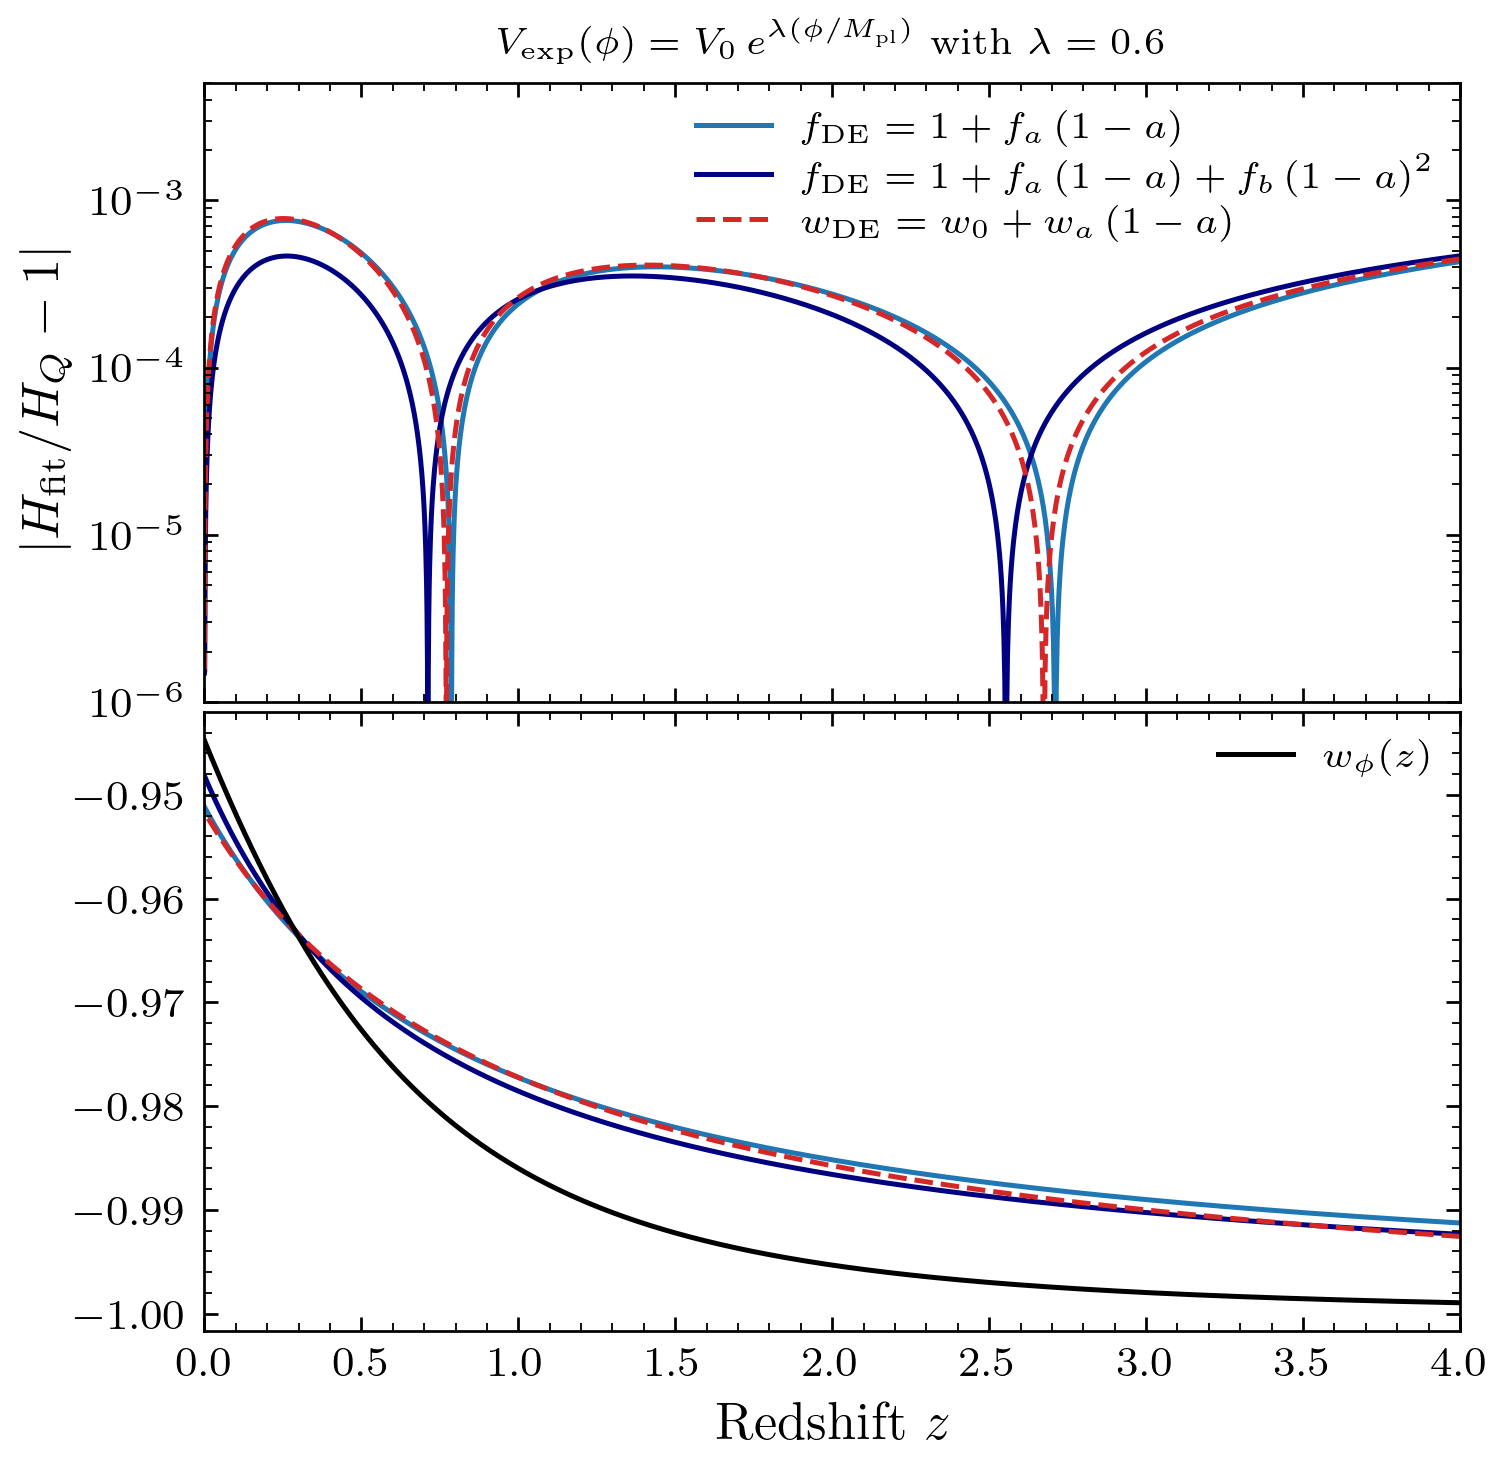

In [20]:
fig1=plt.figure(figsize=(4.5, 4.5))
#fig1=plt.figure(figsize=(7.5, 7.5/1.61803398875*0.5))
gs1 = GridSpec(20,23,figure=fig1)
ax1 = fig1.add_subplot(gs1[:10,:])
ax2 = fig1.add_subplot(gs1[10:,:])
ax1.plot(DictExpDE['z'],np.abs(DictExpDE['H']-Hz_faDE(DictExpDE['z'],ExpDE_fits['faDE'][0],DictExpDE['OmegaM'][-1],DictExpDE['H0']))/DictExpDE['H'],lw=1,c='tab:blue',ls='-', label=r'$f_{\rm DE}=1+f_a\,(1-a)$')
ax1.plot(DictExpDE['z'],np.abs(DictExpDE['H']-Hz_faDE2(DictExpDE['z'],ExpDE_fits['faDE2'][0],ExpDE_fits['faDE2'][1],DictExpDE['OmegaM'][-1],DictExpDE['H0']))/DictExpDE['H'],lw=1,c='navy',ls='-', label=r'$f_{\rm DE}=1+f_a\,(1-a)+f_b\,(1-a)^2$')
ax1.plot(DictExpDE['z'],np.abs(DictExpDE['H']-Hz_w0wa(DictExpDE['z'],ExpDE_fits['w0wa'][0],ExpDE_fits['w0wa'][1],DictExpDE['OmegaM'][-1],DictExpDE['H0']))/DictExpDE['H'],lw=1,c='tab:red',ls='--',label=r'$w_{\rm DE}=w_0+w_a\,(1-a)$')
ax2.plot(DictExpDE['z'],w_faDE(DictExpDE['z'],ExpDE_fits['faDE'][0]),lw=1,c='tab:blue',ls='-')
ax2.plot(DictExpDE['z'],w_faDE2(DictExpDE['z'],ExpDE_fits['faDE2'][0],ExpDE_fits['faDE2'][1]),lw=1,c='navy',ls='-')
ax2.plot(DictExpDE['z'],w_w0wa(DictExpDE['z'],ExpDE_fits['w0wa'][0],ExpDE_fits['w0wa'][1]),lw=1,c='tab:red',ls='--')
ax2.plot(DictExpDE['z'],DictExpDE['wDE'],lw=1,c='k',label='$w_\phi(z)$')
ax1.legend()
ax2.legend()
ax1.set_title(r'$V_{\rm exp}(\phi)=V_0\,e^{\lambda ( \phi/M_{\rm pl})}$ with $\lambda=0.6$',fontsize=7.5)
ax1.set_ylabel(r"$\left|H_{\rm fit}/H_{Q}-1\right|$")
ax2.set_xlabel(r"Redshift $z$")
ax1.set_yscale("log")
ax1.set_ylim(1e-6,5e-3)
ax1.set_xlim(0,4)
ax1.set_xticklabels([])
ax2.set_xlim(0,4)
plt.savefig("figs/Hfits_ExpDE.png")
plt.savefig("figs/Hftis_ExpDE.pdf")
plt.show()
plt.close()

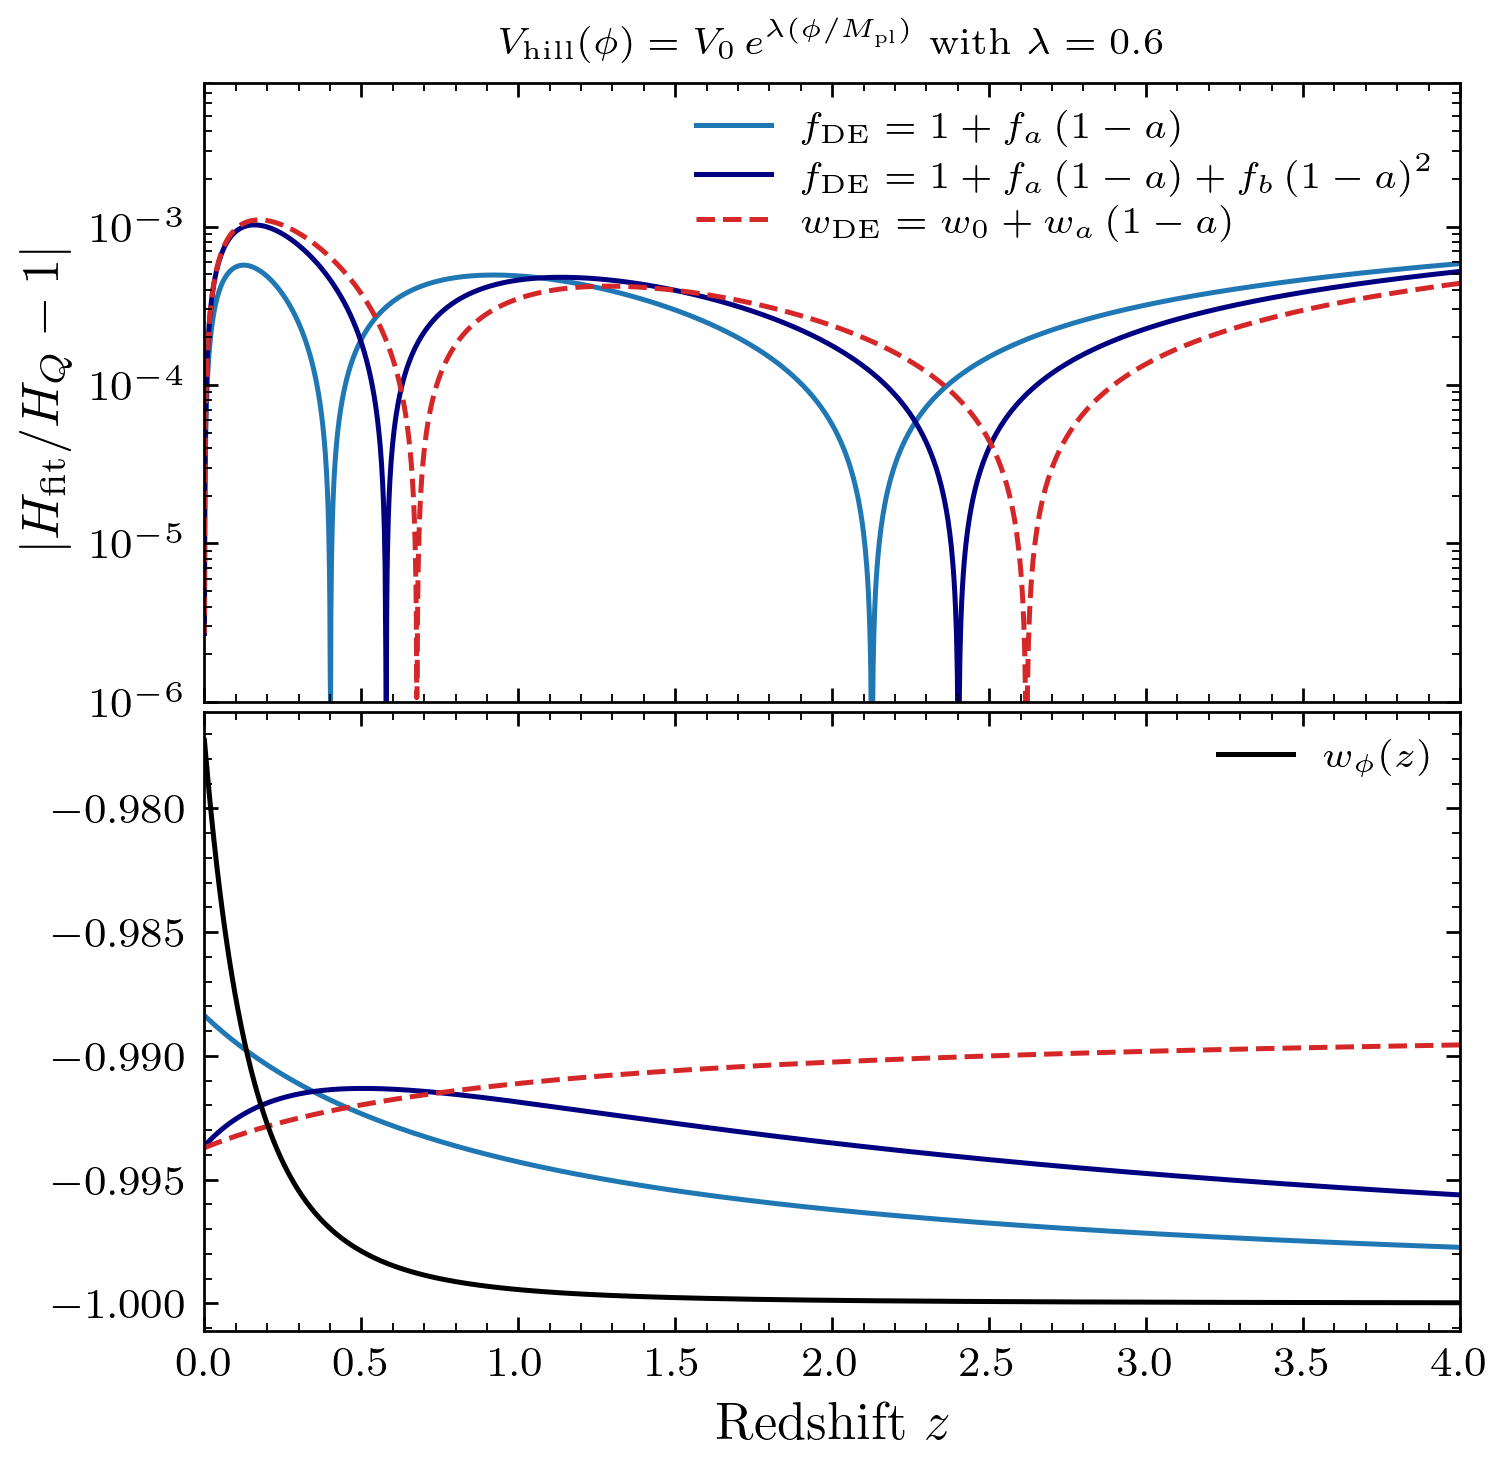

In [23]:
fig1=plt.figure(figsize=(4.5, 4.5))
#fig1=plt.figure(figsize=(7.5, 7.5/1.61803398875*0.5))
gs1 = GridSpec(20,23,figure=fig1)
ax1 = fig1.add_subplot(gs1[:10,:])
ax2 = fig1.add_subplot(gs1[10:,:])
ax1.plot(DictHtDE['z'],np.abs(DictHtDE['H']-Hz_faDE(DictHtDE['z'],HtDE_fits['faDE'][0],DictHtDE['OmegaM'][-1],DictHtDE['H0']))/DictHtDE['H'],lw=1,c='tab:blue',ls='-', label=r'$f_{\rm DE}=1+f_a\,(1-a)$')
ax1.plot(DictHtDE['z'],np.abs(DictHtDE['H']-Hz_faDE2(DictHtDE['z'],HtDE_fits['faDE2'][0],HtDE_fits['faDE2'][1],DictHtDE['OmegaM'][-1],DictHtDE['H0']))/DictHtDE['H'],lw=1,c='navy',ls='-', label=r'$f_{\rm DE}=1+f_a\,(1-a)+f_b\,(1-a)^2$')
ax1.plot(DictHtDE['z'],np.abs(DictHtDE['H']-Hz_w0wa(DictHtDE['z'],HtDE_fits['w0wa'][0],HtDE_fits['w0wa'][1],DictHtDE['OmegaM'][-1],DictHtDE['H0']))/DictHtDE['H'],lw=1,c='tab:red',ls='--',label=r'$w_{\rm DE}=w_0+w_a\,(1-a)$')
ax2.plot(DictHtDE['z'],w_faDE(DictHtDE['z'],HtDE_fits['faDE'][0]),lw=1,c='tab:blue',ls='-')
ax2.plot(DictHtDE['z'],w_faDE2(DictHtDE['z'],HtDE_fits['faDE2'][0],HtDE_fits['faDE2'][1]),lw=1,c='navy',ls='-')
ax2.plot(DictHtDE['z'],w_w0wa(DictHtDE['z'],HtDE_fits['w0wa'][0],HtDE_fits['w0wa'][1]),lw=1,c='tab:red',ls='--')
ax2.plot(DictHtDE['z'],DictHtDE['wDE'],lw=1,c='k',label='$w_\phi(z)$')
ax1.legend()
ax2.legend()
ax1.set_title(r'$V_{\rm hill}(\phi)=V_0\,e^{\lambda ( \phi/M_{\rm pl})}$ with $\lambda=0.6$',fontsize=7.5)
ax1.set_ylabel(r"$\left|H_{\rm fit}/H_{Q}-1\right|$")
ax2.set_xlabel(r"Redshift $z$")
ax1.set_yscale("log")
ax1.set_ylim(1e-6,8e-3)
ax1.set_xlim(0,4)
ax1.set_xticklabels([])
ax2.set_xlim(0,4)
plt.savefig("figs/Hfits_HtDE.png")
plt.savefig("figs/Hftis_HtDE.pdf")
plt.show()
plt.close()